In [1]:
import tensorflow as tf
from keras.models import Sequential,Model
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, Flatten, Concatenate
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model
from keras import optimizers
from keras.metrics import mean_absolute_error
from keras.applications import Xception
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

In [2]:
EPOCHS = 30
LEARNING_RATE = 0.001
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VAL = 16


IMG_SIZE = (224,224)
VALIDATION_FRACTION = 0.25
BATCH_SIZE_TRAIN = 10 
BATCH_SIZE_VAL = 16
SEED = 1234

In [3]:
path = './input/'
train_path = path + 'boneage-training-dataset/'
df = pd.read_csv(path + 'boneage-training-dataset.csv')

files = [train_path + str(i) + '.png' for i in df['id']]
df['file'] = files
df['exists'] = df['file'].map(os.path.exists)

boneage_mean = df['boneage'].mean()
boneage_div = 2 * df['boneage'].std()
df['boneage_zscore'] = df['boneage'].map(lambda x:(x - boneage_mean) / boneage_div)
df.dropna(inplace=True)

df['gender'] = df['male'].map(lambda x: 1 if x else 0)
df['boneage_category'] = pd.cut(df['boneage'], 10)

raw_train_df, raw_valid_df = train_test_split(df, test_size=VALIDATION_FRACTION,random_state=1234, stratify=df['boneage_category'])
train_df = raw_train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace=True)).reset_index(drop=True)
valid_df, test_df = train_test_split(raw_valid_df,test_size=VALIDATION_FRACTION, random_state=1234)

optim = optimizers.Nadam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.0003)
weight_path = "{}_weights_inceptionV3.best.hdf5".format('bone_age')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only=True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=5,min_lr=0.00006)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
def gen_2inputs(imgDatGen, df, batch_size, seed, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, seed=seed, shuffle=True, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

def test_gen_2inputs(imgDatGen, df, batch_size, img_size):
    gen_img = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='boneage_zscore',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    gen_gender = imgDatGen.flow_from_dataframe(dataframe=df,
        x_col='file', y_col='gender',
        batch_size=batch_size, shuffle=False, class_mode='other',
        target_size=img_size, color_mode='rgb',
        drop_duplicates=False)
    
    while True:
        X1i = gen_img.next()
        X2i = gen_gender.next()
        yield [X1i[0], X2i[1]], X1i[1]

In [4]:
train_idg = ImageDataGenerator(zoom_range=0.2,
                               fill_mode='nearest',
                               rotation_range=25,  
                               width_shift_range=0.25,  
                               height_shift_range=0.25,  
                               vertical_flip=False, 
                               horizontal_flip=True,
                               shear_range = 0.2,
                               samplewise_center=False, 
                               samplewise_std_normalization=False)

val_idg = ImageDataGenerator(width_shift_range=0.25, 
                             height_shift_range=0.25, 
                             horizontal_flip=True)

test_idg = ImageDataGenerator()

train_flow = gen_2inputs(train_idg, train_df, BATCH_SIZE_TRAIN, SEED, IMG_SIZE)
valid_flow = gen_2inputs(val_idg, valid_df, BATCH_SIZE_VAL, SEED, IMG_SIZE)
test_flow = test_gen_2inputs(test_idg, test_df, 500, IMG_SIZE)

def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div * in_gt, boneage_div * in_pred)

In [5]:
print("Compiling deep model ...")
IMG_SHAPE = (224, 224,3)


img = Input(shape = IMG_SHAPE)
gender = Input(shape=(1,))

# train the V3 backbone
cnn_vec = InceptionV3(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')(img)

# backbone output
cnn_vec = GlobalAveragePooling2D()(cnn_vec)
cnn_vec = Dropout(0.2)(cnn_vec)

# concate with gender
gender_vec = Dense(32,activation='relu')(gender)

# Concatenation
features = Concatenate(axis=-1)([cnn_vec,gender_vec])

dense_layer = Dense(1024, activation = 'relu')(features)
dense_layer = Dropout(0.2)(dense_layer)
dense_layer = Dense(1024,activation='relu')(dense_layer)
dense_layer = Dropout(0.2)(dense_layer)
output_layer = Dense(1, activation = 'linear')(dense_layer) # linear is what 16bit did

model = Model(inputs=[img,gender],outputs=output_layer)

def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_mean+boneage_div*in_gt, boneage_mean+boneage_div*in_pred)


model.compile(optimizer = 'adam', loss = 'mse', metrics = [mae_months])
model.summary()
print("Model compiled !!!\n")

Compiling deep model ...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 5, 5, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           inception_v3[0][0]               
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
_____________________________________________________________________

In [6]:
# training (DONE)

# plot_model(model, show_shapes=True, to_file='model_inceptionV3.png')

# BATCH_SIZE_TEST = len(test_df) // 3
# STEP_SIZE_TEST = 3
# STEP_SIZE_TRAIN = len(train_df) // BATCH_SIZE_TRAIN
# STEP_SIZE_VALID = len(valid_df) // BATCH_SIZE_VAL

# model_history = model.fit_generator(generator=train_flow,
#                                     steps_per_epoch=STEP_SIZE_TRAIN, 
#                                     validation_data=valid_flow,
#                                     validation_steps=STEP_SIZE_VALID, 
#                                     epochs=EPOCHS,
#                                     callbacks = callbacks_list)

# loss_history = model_history.history['loss']
# history_df = pd.DataFrame.from_dict(model_history.history)
# history_df.to_csv('loss_history_inceptionV3.csv')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Found 10000 validated image filenames.
Found 10000 validated image filenames.


/home/tyler/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
1000/1000 [==============================] - ETA: 0s - loss: 0.7521 - mae_months: 55.5087Found 2364 validated image filenames.
Found 2364 validated image filenames.
1000/1000 [==============================] - 1411s 1s/step - loss: 0.7519 - mae_months: 55.4992 - val_loss: 1.3179 - val_mae_months: 80.4204

Epoch 00001: val_loss improved from inf to 1.31789, saving model to bone_age_weights_inceptionV3.best.hdf5
Epoch 2/30
1000/1000 [==============================] - 1406s 1s/step - loss: 0.2808 - mae_months: 34.4557 - val_loss: 0.2073 - val_mae_months: 26.8510

Epoch 00002: val_loss improved from 1.31789 to 0.20733, saving model to bone_age_weights_inceptionV3.best.hdf5
Epoch 3/30
1000/1000 [==============================] - 1407s 1s/step - loss: 0.1444 - mae_months: 24.5259 - val_loss: 0.8951 - val_mae_months: 72.5916

Epoch 00003: val_loss did not improve from 0.20733
Epoch 4/30
1000/1000 [==============================] - 1409s 1s/step - loss: 0.1490 - mae_months: 24.7739 

Found 789 validated image filenames.
Found 789 validated image filenames.
32/32 [==============================] - 8s 219ms/step


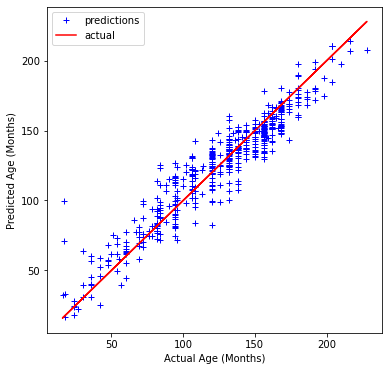

In [8]:
# Testing

model.load_weights("bone_age_weights_inceptionV3.best.hdf5")
test_X, test_Y = next(test_flow)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'
pred_Y = boneage_div*model.predict(test_X, batch_size = 16, verbose = True)+boneage_mean
test_Y_months = boneage_div*test_Y+boneage_mean

fig, ax1 = plt.subplots(1,1,figsize=(6,6))
ax1.plot(test_Y_months, pred_Y, 'b+', label='predictions')
ax1.plot(test_Y_months,test_Y_months,'r-',label='actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')
fig.savefig('test_result.png', dpi = 300)

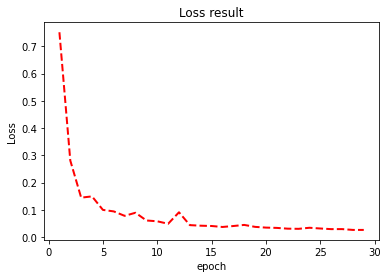

In [10]:
# Plot result: loss and mae generated during training

plot_epoch = [i for i in range(1,30)]
plot_loss = [0.7521, 0.2808, 0.1444, 0.1490, 0.0994, 0.0938, 0.0775, 0.0889, 0.0605, 0.0575, 0.0484, 0.0906, 0.0434, 0.0413, 0.0402, 0.0366, 0.0401, 0.0442, 0.0370, 0.0343, 0.0332, 0.0304, 0.0298, 0.0337, 0.0310, 0.0287, 0.0288, 0.0258, 0.0258,]
plot_mae = [55.5087, 34.4557, 24.5259, 24.7739, 20.2204, 19.4597, 17.8592, 18.5183, 15.4073, 13.5899, 13.9139, 17.8667, 13.3585, 12.8537, 12.8480, 12.2369, 12.7819, 13.4840, 12.0315, 11.6995, 11.5026, 11.2394, 11.0651, 11.5287, 11.1888, 10.6494, 10.8136, 10.3013, 10.1982]

plt.plot(plot_epoch, plot_loss, label="loss", linewidth=2.0,linestyle='--', color='r')

plt.title('Loss result')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

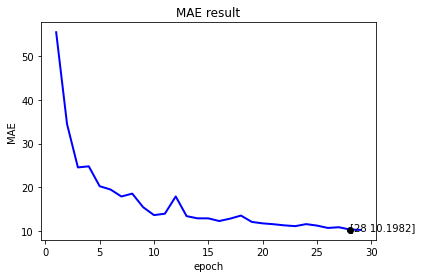

In [11]:
plt.plot(plot_epoch, plot_mae, label="mae", linewidth=2.0,linestyle='-', color='b')
mae_min=np.argmin(plot_mae)
show_min='['+str(mae_min)+' '+str(plot_mae[mae_min])+']'
plt.plot(mae_min,plot_mae[mae_min],'ko')
plt.annotate(show_min,xy=(mae_min,plot_mae[mae_min]),xytext=(mae_min,plot_mae[mae_min]))

plt.title('MAE result')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.show()